In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage as sk
import SimpleITK as sitk
import tifffile as tiff
import common_functions

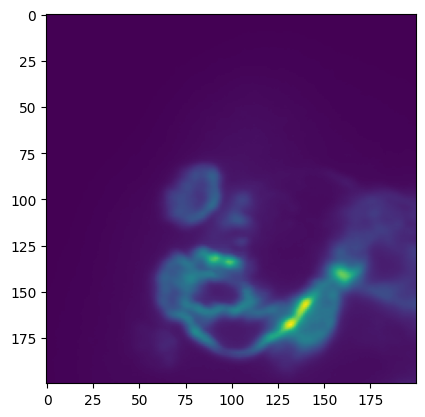

In [17]:
wd = './../../../Desktop/ML/'
image_path = wd + '70_denoised_tp4_apical_dots_total_epithelial_0.tif'

# Load and preprocess the image
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# image = cv2.resize(image, (256, 256, 256))
# image = image.astype('float32') / 255.0
# image = np.reshape(image, (1, 256, 256, 1))

image = sitk.ReadImage(image_path)
image_array = sitk.GetArrayFromImage(image)
original_size = image_array.shape



plt.imshow(image_array[300, 200:400, 200:400])

image_array = image_array[200:400, 200:400, 200:400]

In [18]:
image_array = sk.transform.resize(image_array, (144, 144, 144))
image_array = image_array.astype(np.float32)/255.0

image_array = np.expand_dims(image_array, axis=-1)
image_array = np.expand_dims(image_array, axis=0)

print(image_array.shape)


(1, 144, 144, 144, 1)


In [19]:
# Define the autoencoder model

# Get the shape of the image
depth, height, width = image_array.shape[1:4]

# Define the 3D autoencoder model
input_img = Input(shape=(depth, height, width, 1))

# input_img = Input(shape=(reshaped_image.shape[1], reshaped_image.shape[2], reshaped_image.shape[3], 1))
print(input_img.shape)

(None, 144, 144, 144, 1)


In [20]:
# Encoder
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)


In [21]:
# Decoder
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

In [22]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [23]:
autoencoder.fit(image_array, image_array, epochs=50, batch_size=1, shuffle=True)

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 0.6931
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 0.6897
Epoch 3/50
1/1 [==============================] - 7s 7s/step - loss: 0.6812
Epoch 4/50
1/1 [==============================] - 7s 7s/step - loss: 0.6628
Epoch 5/50
1/1 [==============================] - 7s 7s/step - loss: 0.6249
Epoch 6/50
1/1 [==============================] - 7s 7s/step - loss: 0.5545
Epoch 7/50
1/1 [==============================] - 7s 7s/step - loss: 0.4398
Epoch 8/50
1/1 [==============================] - 7s 7s/step - loss: 0.2831
Epoch 9/50
1/1 [==============================] - 7s 7s/step - loss: 0.1260
Epoch 10/50
1/1 [==============================] - 7s 7s/step - loss: 0.0345
Epoch 11/50
1/1 [==============================] - 7s 7s/step - loss: 0.0081
Epoch 12/50
1/1 [==============================] - 7s 7s/step - loss: 0.0024
Epoch 13/50
1/1 [==============================] - 7s 7s/step - loss: 7.7479e-04
Epoc

In [24]:
reconstructed = autoencoder.predict(image_array)

1/1 [==============================] - 1s 835ms/step


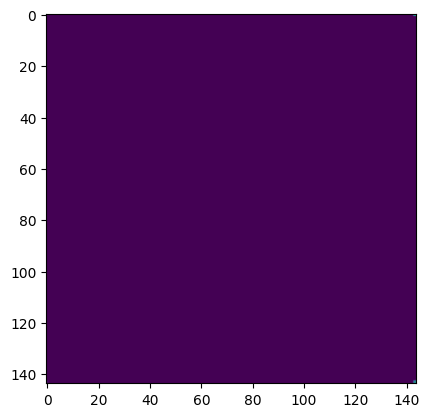

In [25]:
plt.imshow(reconstructed[0, 110, :, :, 0])

In [26]:
difference = np.abs(image_array - reconstructed)
difference = difference[0, :, :, :, 0]

In [27]:
print(difference.shape)
print(image_array.shape)
print(reconstructed.shape)
image_array = image_array[0, :, :, :, 0]
reconstructed = reconstructed[0, :, :, :, 0]

print(original_size)

# difference = sk.transform.resize(difference, (550, 858, 858))
# image_array = sk.transform.resize(image_array, (550, 858, 858))
# reconstructed = sk.transform.resize(reconstructed, (550, 858, 858))
difference = sk.transform.resize(difference, (200, 200, 200))
image_array = sk.transform.resize(image_array, (200, 200, 200))
reconstructed = sk.transform.resize(reconstructed, (200, 200, 200))

(144, 144, 144)
(1, 144, 144, 144, 1)
(1, 144, 144, 144, 1)
(550, 858, 858)


In [28]:
tiff.imwrite(f'{wd}_difference_200.tif', common_functions.normalize_image(difference, 255).astype(np.uint16))
tiff.imwrite(f'{wd}_compressed_image_200.tif', common_functions.normalize_image(image_array, 255).astype(np.uint16))
tiff.imwrite(f'{wd}_reconstructed_200.tif', common_functions.normalize_image(reconstructed, 255).astype(np.uint16))